In [1]:
import datetime, time

# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries
import shapely.geometry
import pyproj

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# Used for making the graph
import networkx as nx

# OpenTNSim
import opentnsim

### Useful graph methods

In [2]:
def distance_over_path(FG, loc1, loc2):
    """This method determines the distance over a path between two points
    (NB: loc1 and loc2 are strings that define the names on the graph)"""

    wgs84 = pyproj.Geod(ellps='WGS84')

    # get path from graph
    path = nx.dijkstra_path(FG, loc1, loc2)

    # intitialise distance over path
    distance_over_path = 0

    # add the length of each path section to distance_path
    for node in enumerate(path[:-1]):
        orig = nx.get_node_attributes(FG, "geometry")[path[node[0]]]
        dest = nx.get_node_attributes(FG, "geometry")[path[node[0] + 1]]

        distance_over_path += int(wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y,
                                            shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2])

        if node[0] + 2 == len(path):
            break

    return distance_over_path

In [3]:
def split_edge(edge, distance):
    """compute points (list of shapely points) and edges ({e: linestring}) that we can use to replace an edge by points in between"""
    distances = np.arange(0, edge['geometry'].length + distance, distance)
    
    # The determine the points based on the distances
    points = [
        edge['geometry'].interpolate(distance) 
        for distance 
        in distances
    ]
    
    return points


In [4]:

def split_and_replace_edge(FG, e_replace, edge_info, distance):
    """remove edge from the network and replace it by points in between"""
    
    # determine the points that we want to intersect
    intersection_points = split_edge(edge_info, distance=distance)
    
    # Try and remove the previous edges, if it fails, that's ok
    try:
        FG.remove_edge(e_replace[0], e_replace[1])
    except nx.NetworkXError:
        pass
    
    # also remove the oposite edge direction
    try:
        FG.remove_edge(e_replace[1], e_replace[0])
    except nx.NetworkXError:
        pass

    # define Site class
    Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})
    
    # start at the start of our replaced edge
    nodes = []

    node_id = f'{e_replace[0]}'
    node_properties = dict(
        name=node_id,
        geometry=shapely.geometry.Point((edge_info['geometry'].xy[0][0], edge_info['geometry'].xy[1][0]))
    )
    nodes.append(node_properties)

    # all the points in between
    for node_i, point in enumerate(intersection_points[1:-1]):
        node_id = f'{e_replace[0]}-{node_i}-{e_replace[1]}'
        node_properties = dict(
            name=node_id,
            geometry=point,
        )
        nodes.append(node_properties)
    
    # end at the end of our edge
    node_id = f'{e_replace[1]}'
    node_properties = dict(
        name=node_id,
        geometry=shapely.geometry.Point((edge_info['geometry'].xy[0][1], edge_info['geometry'].xy[1][1]))
    )
    nodes.append(node_properties)

    # add the nodes in between
    for node in nodes:
        FG.add_node(node['name'], geometry = node['geometry'])    
        
    # now loop over all the node pairs in between our edge
    edges = []
    for index, node in enumerate(nodes[:-1]):
        e = (nodes[index]['name'], nodes[index+1]['name'])

        # create a new geometry
        edge_geometry = shapely.geometry.LineString([
            nodes[index]['geometry'], 
            nodes[index+1]['geometry']
        ])
        # we might want to copy the old properties
        # for now this is hard coded
        # at least replace e, edge_geometry
        edge_properties = dict(
            GeneralDepth= edge_info['GeneralDepth'], 
            width= edge_info['width'], 
            geometry=edge_geometry, 
            energy_consumption=edge_info['energy_consumption'],
            e=tuple(e)
        )
        edges.append(edge_properties)

    # now that we have all our edges computed
    for edge in edges:
        # insert them in two directions
        e = edge['e']
        FG.add_edge(e[0], e[1], weight = 1, Info = edge_properties)
        FG.add_edge(e[1], e[0], weight = 1, Info = edge_properties)

    
    return FG, nodes, edges

### Initialise graph

In [5]:
# We're in engineering cordinates (m)
coords = [
    [0,0],
    [0.8983,0], 
    [1.7966,0],
    [1.7966,1.3566],
    [1.7966,2.2609],
    [2.7527,0.9560],
    [3.3903,1.5931],
    [3.1441,0],
    [4.0424, 0],
    [1.9560,-0.1593],
    [3.3904,-1.5931]] 


# these are the indices of the points above
edge_indices = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [2, 5],
    [5, 6],
    [2, 7],
    [7, 8],
    [2, 9],
    [9, 10]   
]

depths = [12.5, 6, 6, 6, 4.5, 6, 2.5, 6, 2.5, 6] 

widths = [300, 150, 150, 150, 150, 150, 150, 150, 150, 150]
energy_consumption = [150, 150, 150, 150, 150, 550, 150, 150, 150, 150]

points = [
    shapely.geometry.Point(*coord )
    for coord 
    in coords
]

In [6]:
# define Site class
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

In [7]:
FG = nx.DiGraph()

nodes = []
for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(points[index].x, points[index].y)}
    nodes.append(Node(**data_node))

for node in nodes:
    FG.add_node(node.name, geometry = node.geometry)    
    
for index, edge in enumerate(edge_indices):
    edge_geometry = shapely.geometry.LineString([points[edge[0]], points[edge[1]]])
    edge_properties = dict(
        GeneralDepth = depths[index],
        width = widths[index],
        geometry = edge_geometry, 
        energy_consumption=energy_consumption[index],
        e = tuple(edge)
    )
    FG.add_edge("Node " + str(edge[0]), "Node " + str(edge[1]), weight = 1, Info = edge_properties)

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

In [8]:
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)

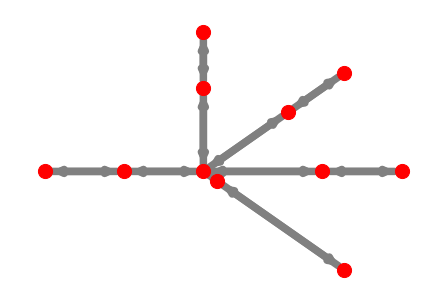

In [9]:
# show graph
energy_consumption = [20,20,20,20,20,20,20,20,20,20,20,80,20 ] 
for edge in FG.edges(data = True):
    edge_width = FG.edges[(edge[0], edge[1])]['Info']['energy_consumption']*0.05
edge_colors = ["grey"]

# mapping = {0: "a", 1: "b", 2: "c"}
# H = nx.relabel_nodes(FG, mapping)
# nx.draw_networkx(FG, positions)
nx.draw(FG, positions, node_size=200, width = edge_width, edge_color = edge_colors, node_color = 'r')


plt.savefig('graph.pdf', bbox_inches = 'tight', dpi=600, format='pdf') 
plt.show()


### Verify graph

In [10]:
FG.edges[('Node 0', 'Node 1')]

{'weight': 1,
 'Info': {'GeneralDepth': 12.5,
  'width': 300,
  'geometry': <shapely.geometry.linestring.LineString at 0x226cae06880>,
  'energy_consumption': 150,
  'e': (0, 1)}}

In [11]:
# inspect if properties were set correctly
for edge in FG.edges(data = True):
    print('{}, {}: general depth {} m'.format(edge[0], edge[1], FG.edges[(edge[0], edge[1])]['Info']['GeneralDepth']))
    print('Distance from {} to {} is {} m'.format(edge[0], edge[1],distance_over_path(FG, edge[0], edge[1])))

C:\Users\manjiang\AppData\Local\Temp\ipykernel_4212\3201310092.py:18: ShapelyDeprecationWarning:

The proxy geometries (through the 'asShape()', 'asPoint()' or 'PointAdapter()' constructors) are deprecated and will be removed in Shapely 2.0. Use the 'shape()' function or the standard 'Point()' constructor instead.

Exception ignored in: <function BaseGeometry.__del__ at 0x00000226BA09F940>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x00000226BA09F940>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\si

Node 0, Node 1: general depth 12.5 m
Distance from Node 0 to Node 1 is 99998 m
Node 1, Node 0: general depth 12.5 m
Distance from Node 1 to Node 0 is 99998 m
Node 1, Node 2: general depth 6 m
Distance from Node 1 to Node 2 is 99998 m
Node 2, Node 1: general depth 6 m
Distance from Node 2 to Node 1 is 99998 m
Node 2, Node 3: general depth 6 m
Distance from Node 2 to Node 3 is 150005 m
Node 2, Node 5: general depth 4.5 m
Distance from Node 2 to Node 5 is 150004 m
Node 2, Node 7: general depth 2.5 m
Distance from Node 2 to Node 7 is 150003 m
Node 2, Node 9: general depth 2.5 m
Distance from Node 2 to Node 9 is 25002 m
Node 3, Node 2: general depth 6 m
Distance from Node 3 to Node 2 is 150005 m
Node 3, Node 4: general depth 6 m
Distance from Node 3 to Node 4 is 99993 m
Node 4, Node 3: general depth 6 m
Distance from Node 4 to Node 3 is 99993 m
Node 5, Node 2: general depth 4.5 m
Distance from Node 5 to Node 2 is 150004 m
Node 5, Node 6: general depth 6 m
Distance from Node 5 to Node 6 is 9

### Add detail to graph

In [12]:
distance = 0.89835/10
edge_name = ("Node " + str(edge_indices[0][0]), "Node " + str(edge_indices[0][1]))
print(edge_name)
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_0 = split_and_replace_edge(FG, edge_name, edge_info, distance=distance)

edge_name = ("Node " + str(edge_indices[1][0]), "Node " + str(edge_indices[1][1]))
print(edge_name)
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_1 = split_and_replace_edge(FG, edge_name, edge_info, distance=distance)

edge_name = ("Node " + str(edge_indices[2][0]), "Node " + str(edge_indices[2][1]))
print(edge_name)
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_2 = split_and_replace_edge(FG, edge_name, edge_info, distance=distance)

edge_name = ("Node " + str(edge_indices[3][0]), "Node " + str(edge_indices[3][1]))
print(edge_name)
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_3 = split_and_replace_edge(FG, edge_name, edge_info, distance=distance)

edge_name = ("Node " + str(edge_indices[4][0]), "Node " + str(edge_indices[4][1]))
print(edge_name)
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_4 = split_and_replace_edge(FG, edge_name, edge_info, distance=distance)

edge_name = ("Node " + str(edge_indices[5][0]), "Node " + str(edge_indices[5][1]))
print(edge_name)
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_5 = split_and_replace_edge(FG, edge_name, edge_info, distance=distance)

edge_name = ("Node " + str(edge_indices[6][0]), "Node " + str(edge_indices[6][1]))
print(edge_name)
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_6 = split_and_replace_edge(FG, edge_name, edge_info, distance=distance)

edge_name = ("Node " + str(edge_indices[7][0]), "Node " + str(edge_indices[7][1]))
print(edge_name)
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_7 = split_and_replace_edge(FG, edge_name, edge_info, distance=distance)

edge_name = ("Node " + str(edge_indices[8][0]), "Node " + str(edge_indices[8][1]))
print(edge_name)
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_8 = split_and_replace_edge(FG, edge_name, edge_info, distance=distance)

edge_name = ("Node " + str(edge_indices[9][0]), "Node " + str(edge_indices[9][1]))
print(edge_name)
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_9 = split_and_replace_edge(FG, edge_name, edge_info, distance=distance)

('Node 0', 'Node 1')
('Node 1', 'Node 2')
('Node 2', 'Node 3')
('Node 3', 'Node 4')
('Node 2', 'Node 5')
('Node 5', 'Node 6')
('Node 2', 'Node 7')
('Node 7', 'Node 8')
('Node 2', 'Node 9')
('Node 9', 'Node 10')


In [13]:
positions = {}
for node in FG.nodes:
    positions[node] = (FG.nodes[node]['geometry'].x, FG.nodes[node]['geometry'].y)   

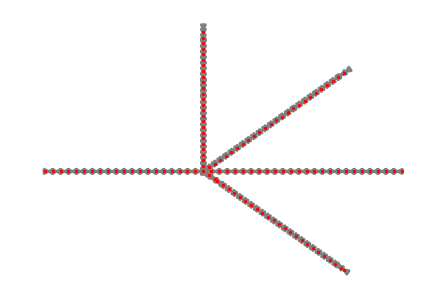

In [14]:
# show graph
# show graph
for edge in FG.edges(data = True):
    edge_width = FG.edges[(edge[0], edge[1])]['Info']['GeneralDepth']*0.5
edge_colors = ["grey"]

# nx.draw_networkx(FG, positions)
nx.draw(FG, positions, node_size=5, width = edge_width, edge_color = edge_colors, node_color = 'r')

# nx.draw(FG, positions)
plt.show()

### Verify detailed graph

In [15]:
for edge in FG.edges:
    print(edge)
    # print(FG.edges[edge]['Info']['distance'])

('Node 0', 'Node 0-0-Node 1')
('Node 1', 'Node 0-8-Node 1')
('Node 1', 'Node 1-0-Node 2')
('Node 2', 'Node 1-8-Node 2')
('Node 2', 'Node 2-0-Node 3')
('Node 2', 'Node 2-0-Node 5')
('Node 2', 'Node 2-0-Node 7')
('Node 2', 'Node 2-0-Node 9')
('Node 3', 'Node 2-14-Node 3')
('Node 3', 'Node 3-0-Node 4')
('Node 4', 'Node 3-9-Node 4')
('Node 5', 'Node 2-14-Node 5')
('Node 5', 'Node 5-0-Node 6')
('Node 6', 'Node 5-9-Node 6')
('Node 7', 'Node 2-13-Node 7')
('Node 7', 'Node 7-0-Node 8')
('Node 8', 'Node 7-8-Node 8')
('Node 9', 'Node 2-1-Node 9')
('Node 9', 'Node 9-0-Node 10')
('Node 10', 'Node 9-21-Node 10')
('Node 0-0-Node 1', 'Node 0')
('Node 0-0-Node 1', 'Node 0-1-Node 1')
('Node 0-1-Node 1', 'Node 0-0-Node 1')
('Node 0-1-Node 1', 'Node 0-2-Node 1')
('Node 0-2-Node 1', 'Node 0-1-Node 1')
('Node 0-2-Node 1', 'Node 0-3-Node 1')
('Node 0-3-Node 1', 'Node 0-2-Node 1')
('Node 0-3-Node 1', 'Node 0-4-Node 1')
('Node 0-4-Node 1', 'Node 0-3-Node 1')
('Node 0-4-Node 1', 'Node 0-5-Node 1')
('Node 0-5-N

In [16]:
df_split_edge_0 = pd.DataFrame(split_edge_0)
df_split_edge_0.head(3)

,GeneralDepth,width,geometry,energy_consumption,e
0,12.5,300,"LINESTRING (0 0, 0.089835 0)",150,"(Node 0, Node 0-0-Node 1)"
1,12.5,300,"LINESTRING (0.089835 0, 0.17967 0)",150,"(Node 0-0-Node 1, Node 0-1-Node 1)"
2,12.5,300,"LINESTRING (0.17967 0, 0.269505 0)",150,"(Node 0-1-Node 1, Node 0-2-Node 1)"


In [17]:
df_split_edge_1 = pd.DataFrame(split_edge_1)
df_split_edge_1.head(3)

,GeneralDepth,width,geometry,energy_consumption,e
0,6,150,"LINESTRING (0.8983 0, 0.988135 0)",150,"(Node 1, Node 1-0-Node 2)"
1,6,150,"LINESTRING (0.988135 0, 1.07797 0)",150,"(Node 1-0-Node 2, Node 1-1-Node 2)"
2,6,150,"LINESTRING (1.07797 0, 1.167805 0)",150,"(Node 1-1-Node 2, Node 1-2-Node 2)"


In [18]:
df_split_edge_2 = pd.DataFrame(split_edge_2)
df_split_edge_2.head(3)

,GeneralDepth,width,geometry,energy_consumption,e
0,6,150,"LINESTRING (1.7966 0, 1.7966 0.089835)",150,"(Node 2, Node 2-0-Node 3)"
1,6,150,"LINESTRING (1.7966 0.089835, 1.7966 0.17967)",150,"(Node 2-0-Node 3, Node 2-1-Node 3)"
2,6,150,"LINESTRING (1.7966 0.17967, 1.7966 0.269505)",150,"(Node 2-1-Node 3, Node 2-2-Node 3)"


In [19]:
df_split_edge_3 = pd.DataFrame(split_edge_3)
df_split_edge_3.head(3)

,GeneralDepth,width,geometry,energy_consumption,e
0,6,150,"LINESTRING (1.7966 1.3566, 1.7966 1.4464350000...",150,"(Node 3, Node 3-0-Node 4)"
1,6,150,"LINESTRING (1.7966 1.4464350000000001, 1.7966 ...",150,"(Node 3-0-Node 4, Node 3-1-Node 4)"
2,6,150,"LINESTRING (1.7966 1.53627, 1.7966 1.626105)",150,"(Node 3-1-Node 4, Node 3-2-Node 4)"


In [20]:
df_split_edge_4 = pd.DataFrame(split_edge_4)
df_split_edge_4.head(3)

,GeneralDepth,width,geometry,energy_consumption,e
0,4.5,150,"LINESTRING (1.7966 0, 1.860126259756641 0.0635...",150,"(Node 2, Node 2-0-Node 5)"
1,4.5,150,LINESTRING (1.860126259756641 0.06351961544540...,150,"(Node 2-0-Node 5, Node 2-1-Node 5)"
2,4.5,150,LINESTRING (1.9236525195132823 0.1270392308908...,150,"(Node 2-1-Node 5, Node 2-2-Node 5)"


In [21]:
df_split_edge_5 = pd.DataFrame(split_edge_5)
df_split_edge_5.head(3)

,GeneralDepth,width,geometry,energy_consumption,e
0,6,150,"LINESTRING (2.7527 0.956, 2.8162478496179135 1...",550,"(Node 5, Node 5-0-Node 6)"
1,6,150,LINESTRING (2.8162478496179135 1.0194980159842...,550,"(Node 5-0-Node 6, Node 5-1-Node 6)"
2,6,150,LINESTRING (2.879795699235827 1.08299603196854...,550,"(Node 5-1-Node 6, Node 5-2-Node 6)"


In [22]:
df_split_edge_6 = pd.DataFrame(split_edge_6)
df_split_edge_6.head(3)

,GeneralDepth,width,geometry,energy_consumption,e
0,2.5,150,"LINESTRING (1.7966 0, 1.886435 0)",150,"(Node 2, Node 2-0-Node 7)"
1,2.5,150,"LINESTRING (1.886435 0, 1.97627 0)",150,"(Node 2-0-Node 7, Node 2-1-Node 7)"
2,2.5,150,"LINESTRING (1.97627 0, 2.066105 0)",150,"(Node 2-1-Node 7, Node 2-2-Node 7)"


In [23]:
df_split_edge_7 = pd.DataFrame(split_edge_7)
df_split_edge_7.head(3)

,GeneralDepth,width,geometry,energy_consumption,e
0,6,150,"LINESTRING (3.1441 0, 3.233935 0)",150,"(Node 7, Node 7-0-Node 8)"
1,6,150,"LINESTRING (3.233935 0, 3.3237699999999997 0)",150,"(Node 7-0-Node 8, Node 7-1-Node 8)"
2,6,150,"LINESTRING (3.3237699999999997 0, 3.413605 0)",150,"(Node 7-1-Node 8, Node 7-2-Node 8)"


In [24]:
df_split_edge_8 = pd.DataFrame(split_edge_8)
df_split_edge_8.head(3)

,GeneralDepth,width,geometry,energy_consumption,e
0,2.5,150,"LINESTRING (1.7966 0, 1.8601428664511868 -0.06...",150,"(Node 2, Node 2-0-Node 9)"
1,2.5,150,LINESTRING (1.8601428664511868 -0.063503002670...,150,"(Node 2-0-Node 9, Node 2-1-Node 9)"
2,2.5,150,LINESTRING (1.9236857329023738 -0.127006005340...,150,"(Node 2-1-Node 9, Node 9)"


In [25]:
df_split_edge_9 = pd.DataFrame(split_edge_9)
df_split_edge_9.head(3)

,GeneralDepth,width,geometry,energy_consumption,e
0,6,150,"LINESTRING (1.956 -0.1593, 2.0195362246885424 ...",150,"(Node 9, Node 9-0-Node 10)"
1,6,150,LINESTRING (2.0195362246885424 -0.222809647907...,150,"(Node 9-0-Node 10, Node 9-1-Node 10)"
2,6,150,LINESTRING (2.083072449377085 -0.2863192958148...,150,"(Node 9-1-Node 10, Node 9-2-Node 10)"


### Create vessels - add VesselProperties and ConsumesEnergy mixins

In [26]:
row = {
    "rws_type": "M8",
    "fuel": 3000,
    "H2": 999000,
    "Battery": 3300,
    "E-LNG": 432000,
    "E-Methanol": 165900
}
rows = [row]
ships = pd.DataFrame(rows)
ships

,rws_type,fuel,H2,Battery,E-LNG,E-Methanol
0,M8,3000,999000,3300,432000,165900


In [27]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [28]:
# Create a dict with all important settings
# NB: set both "v" and "P_tot_given" to None, as they will be set later
# Note that we set "h_squat" as "True". 
# The squat effect makes a great difference for the actual water depth and resistance calculation in shallow water. 
# Here we need to calculate the water depth reduced by squat since what we give the ship is a route with undisturbed water depth h_0.
# M8
data_vessel = {"env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": 3.5,  # m/s
               "type":None,
               "B": 11.4,
               "L": 110,
               "H_e": None, 
               "H_f": None, 
               "T": None,
               "safety_margin": 0.2, # for tanker vessel with sandy bed the safety margin is recommended as 0.2 m
               "h_squat": True, # if consider the ship squat while moving, set to True, otherwise set to False. 
               "P_installed": 1750.0,
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "x": 2 ,
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
              }             

vessel = TransportResource(**data_vessel)

### Create simulation function

In [29]:
def run_simulation(FG, V_s, T, path):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.v = V_s
    vessel._T = T
    # vessel.P_tot_given = P_tot_given    

    # Start the simulation
    env.process(vessel.move())
    env.run()

    return vessel

### Define paths with two-way traffic (dir1 and dir2)

In [30]:
path_0_dir1 = nx.dijkstra_path(FG, 'Node 0', 'Node 4' )
path_0_dir2 = nx.dijkstra_path(FG, 'Node 4', 'Node 0' )
path_1_dir1 = nx.dijkstra_path(FG, 'Node 0', 'Node 6' )
path_1_dir2 = nx.dijkstra_path(FG, 'Node 6', 'Node 0' )
path_2_dir1 = nx.dijkstra_path(FG, 'Node 0', 'Node 8' )
path_2_dir2 = nx.dijkstra_path(FG, 'Node 8', 'Node 0' )
path_3_dir1 = nx.dijkstra_path(FG, 'Node 0', 'Node 10' )
path_3_dir2 = nx.dijkstra_path(FG, 'Node 10', 'Node 0' )

### Define simulation for getting energy consumption details of a single M8 vessel along each path 

In [31]:
def get_energy_M8(FG, V_s, T, path):
    vessel_M8 = run_simulation(FG, V_s, T, path)
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel = vessel_M8)
    energycalculation.calculate_energy_consumption()
    
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    df['diesel_use_kg'] = df['total_fuel_consumption']/1000
    df['diesel_use_kg_cum'] = df['diesel_use_kg'].cumsum()
    df['LH2_use_kg'] = df['total_LH2_consumption']/1000
    df['LH2_use_kg_cum'] = df['LH2_use_kg'].cumsum()
    df['eLNG_use_kg'] = df['total_eLNG_consumption']/1000
    df['eLNG_use_kg_cum'] = df['eLNG_use_kg'].cumsum()
    df['eMethanol_use_kg'] = df['total_eMethanol_consumption']/1000
    df['eMethanol_use_kg_cum'] = df['eMethanol_use_kg'].cumsum()
    df['eNH3_use_kg'] = df['total_eNH3_consumption']/1000
    df['eNH3_use_kg_cum'] = df['eNH3_use_kg'].cumsum()
    df['diesel_use_L'] = df['total_fuel_consumption_vol']
    df['diesel_use_L_cum'] = df['diesel_use_L'].cumsum()
    df['LH2_use_L'] = df['total_LH2_consumption_vol']
    df['LH2_use_L_cum'] = df['LH2_use_L'].cumsum()
    df['eLNG_use_L'] = df['total_eLNG_consumption_vol']
    df['eLNG_use_L_cum'] = df['eLNG_use_L'].cumsum()
    df['eMethanol_use_L'] = df['total_eMethanol_consumption_vol']
    df['eMethanol_use_L_cum'] = df['eMethanol_use_L'].cumsum()
    df['eNH3_use_L'] = df['total_eNH3_consumption_vol']
    df['eNH3_use_L_cum'] = df['eNH3_use_L'].cumsum()
    df['Battery2000kWh_use_perc'] = df['total_Battery2000kWh_consumption']
    df['Battery2000kWh_use_20ftContainers_cum'] = df['Battery2000kWh_use_perc'].cumsum()
    df['energy_consumption_kWh_cum'] = df['total_energy'].cumsum()

    energy_M8 = df[['edge_start','edge_stop','distance','delta_t','water depth','total_energy','energy_consumption_kWh_cum','diesel_use_kg','diesel_use_kg_cum',
                    'LH2_use_kg','LH2_use_kg_cum', 'eLNG_use_kg','eLNG_use_kg_cum', 'eMethanol_use_kg', 'eMethanol_use_kg_cum','eNH3_use_kg','eNH3_use_kg_cum',
                    'Battery2000kWh_use_perc', 'Battery2000kWh_use_20ftContainers_cum',
                    'diesel_use_L','diesel_use_L_cum',
                    'LH2_use_L','LH2_use_L_cum', 'eLNG_use_L','eLNG_use_L_cum', 'eMethanol_use_L', 'eMethanol_use_L_cum','eNH3_use_L','eNH3_use_L_cum',
                    ]]
    energy_M8.columns = ['edge_start','edge_stop','sailing_distance_m','delta_t_sec','water_depth_m','energy_consumption_kWh', 'energy_consumption_kWh_cum','diesel_use_kg', 'diesel_use_kg_cum',
                        'LH2_use_kg','LH2_use_kg_cum', 'eLNG_use_kg','eLNG_use_kg_cum', 'eMethanol_use_kg', 'eMethanol_use_kg_cum','eNH3_use_kg','eNH3_use_kg_cum',
                     'Battery2000kWh_use_perc', 'Battery2000kWh_use_20ftContainers_cum',
                        'diesel_use_L','diesel_use_L_cum',
                    'LH2_use_L','LH2_use_L_cum', 'eLNG_use_L','eLNG_use_L_cum', 'eMethanol_use_L', 'eMethanol_use_L_cum','eNH3_use_L','eNH3_use_L_cum']
    energy_M8

    return energy_M8

### Run simulation

In [32]:
energy_M8_path_0_dir1 = get_energy_M8(FG, V_s=3, T=3.5, path = path_0_dir1)
pd.options.display.max_columns = None
energy_M8_path_0_dir1.tail(3) 

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,sailing_distance_m,delta_t_sec,water_depth_m,energy_consumption_kWh,energy_consumption_kWh_cum,diesel_use_kg,diesel_use_kg_cum,LH2_use_kg,LH2_use_kg_cum,eLNG_use_kg,eLNG_use_kg_cum,eMethanol_use_kg,eMethanol_use_kg_cum,eNH3_use_kg,eNH3_use_kg_cum,Battery2000kWh_use_perc,Battery2000kWh_use_20ftContainers_cum,diesel_use_L,diesel_use_L_cum,LH2_use_L,LH2_use_L_cum,eLNG_use_L,eLNG_use_L_cum,eMethanol_use_L,eMethanol_use_L_cum,eNH3_use_L,eNH3_use_L_cum
44,POINT (1.7966 2.0752800000000002),POINT (1.7966 2.165115),9933.576615,3311.192205,5.867175,292.814123,12809.223965,85.667953,3751.312373,22.683571,993.290439,75.168798,3291.565067,136.593653,5981.296859,146.105010,6397.789484,0.232817,10.194834,100.537512,4402.435176,295.525391,12940.755724,177.291189,7763.400495,172.103646,7536.243251,192.842201,8444.363449
45,POINT (1.7966 2.165115),POINT (1.7966 2.25495),9933.588424,3311.196141,5.867175,292.814472,13102.038437,85.668055,3836.980428,22.683598,1015.974037,75.168888,3366.733955,136.593815,6117.890674,146.105183,6543.894667,0.232818,10.427651,100.537631,4502.972807,295.525743,13236.281467,177.291400,7940.691895,172.103850,7708.347102,192.842430,8637.205879
46,POINT (1.7966 2.25495),POINT (1.7966 2.2609),657.927196,219.309066,5.867175,19.393858,13121.432295,5.674016,3842.654445,1.502393,1017.476430,4.978629,3371.712584,9.046961,6126.937635,9.676923,6553.571590,0.015420,10.443071,6.658867,4509.631674,19.573433,13255.854899,11.742467,7952.434362,11.398882,7719.745984,12.772452,8649.978331


In [33]:
energy_M8_path_0_dir2 = get_energy_M8(FG, V_s=3, T=3.5, path = path_0_dir2)
energy_M8_path_0_dir2.tail(3)

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,sailing_distance_m,delta_t_sec,water_depth_m,energy_consumption_kWh,energy_consumption_kWh_cum,diesel_use_kg,diesel_use_kg_cum,LH2_use_kg,LH2_use_kg_cum,eLNG_use_kg,eLNG_use_kg_cum,eMethanol_use_kg,eMethanol_use_kg_cum,eNH3_use_kg,eNH3_use_kg_cum,Battery2000kWh_use_perc,Battery2000kWh_use_20ftContainers_cum,diesel_use_L,diesel_use_L_cum,LH2_use_L,LH2_use_L_cum,eLNG_use_L,eLNG_use_L_cum,eMethanol_use_L,eMethanol_use_L_cum,eNH3_use_L,eNH3_use_L_cum
44,POINT (0.269505 0),POINT (0.17967 0),10000.386455,3333.462152,12.426703,280.465389,12560.501516,82.429857,3677.794731,21.826172,973.824086,72.327551,3227.057482,131.430656,5864.076324,140.5825,6272.40659,0.224017,9.995037,96.737372,4316.156929,284.355057,12687.144785,170.589897,7611.254567,165.598434,7388.549116,185.553108,8278.872114
45,POINT (0.17967 0),POINT (0.089835 0),10000.386455,3333.462152,12.426703,280.465389,12840.966906,82.429857,3760.224588,21.826172,995.650258,72.327551,3299.385033,131.430656,5995.506980,140.5825,6412.98909,0.224017,10.219054,96.737372,4412.894302,284.355057,12971.499842,170.589897,7781.844465,165.598434,7554.147550,185.553108,8464.425223
46,POINT (0.089835 0),POINT (0 0),10000.386455,3333.462152,12.426703,280.465389,13121.432295,82.429857,3842.654445,21.826172,1017.476430,72.327551,3371.712584,131.430656,6126.937635,140.5825,6553.57159,0.224017,10.443071,96.737372,4509.631674,284.355057,13255.854899,170.589897,7952.434362,165.598434,7719.745984,185.553108,8649.978331


In [34]:
energy_M8_path_1_dir1 = get_energy_M8(FG, V_s=3, T=3.5, path = path_1_dir1)
pd.options.display.max_columns = None
energy_M8_path_1_dir1.tail(3) 

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,sailing_distance_m,delta_t_sec,water_depth_m,energy_consumption_kWh,energy_consumption_kWh_cum,diesel_use_kg,diesel_use_kg_cum,LH2_use_kg,LH2_use_kg_cum,eLNG_use_kg,eLNG_use_kg_cum,eMethanol_use_kg,eMethanol_use_kg_cum,eNH3_use_kg,eNH3_use_kg_cum,Battery2000kWh_use_perc,Battery2000kWh_use_20ftContainers_cum,diesel_use_L,diesel_use_L_cum,LH2_use_L,LH2_use_L_cum,eLNG_use_L,eLNG_use_L_cum,eMethanol_use_L,eMethanol_use_L_cum,eNH3_use_L,eNH3_use_L_cum
44,POINT (3.2610827969433087 1.4639841278741872),POINT (3.324630646561222 1.5274821438584607),9965.330158,3321.776719,5.867175,293.750129,13049.662533,85.941798,3814.942883,22.756081,1010.138830,75.409082,3347.397252,137.030286,6082.752812,146.572047,6506.310067,0.233562,10.367761,100.858889,4477.110162,296.470064,13160.259409,177.857916,7895.084846,172.653790,7664.074515,193.458638,8587.598429
45,POINT (3.324630646561222 1.5274821438584607),POINT (3.3881784961791355 1.5909801598427342),9965.185784,3321.728595,5.867175,293.745874,13343.408406,85.940553,3900.883436,22.755751,1032.894581,75.407989,3422.805241,137.028301,6219.781113,146.569924,6652.879991,0.233558,10.601319,100.857427,4577.967589,296.465769,13456.725177,177.855339,8072.940185,172.651289,7836.725804,193.455835,8781.054264
46,POINT (3.3881784961791355 1.5909801598427342),POINT (3.3903 1.5931),332.678716,110.892905,5.867175,9.806440,13353.214846,2.869048,3903.752484,0.759680,1033.654261,2.517428,3425.322668,4.574566,6224.355679,4.893104,6657.773095,0.007797,10.609116,3.367034,4581.334623,9.897242,13466.622419,5.937540,8078.877725,5.763807,7842.489611,6.458348,8787.512613


In [35]:
energy_M8_path_1_dir2 = get_energy_M8(FG, V_s=3, T=3.5, path = path_1_dir2)
energy_M8_path_1_dir2.tail(3) 

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,sailing_distance_m,delta_t_sec,water_depth_m,energy_consumption_kWh,energy_consumption_kWh_cum,diesel_use_kg,diesel_use_kg_cum,LH2_use_kg,LH2_use_kg_cum,eLNG_use_kg,eLNG_use_kg_cum,eMethanol_use_kg,eMethanol_use_kg_cum,eNH3_use_kg,eNH3_use_kg_cum,Battery2000kWh_use_perc,Battery2000kWh_use_20ftContainers_cum,diesel_use_L,diesel_use_L_cum,LH2_use_L,LH2_use_L_cum,eLNG_use_L,eLNG_use_L_cum,eMethanol_use_L,eMethanol_use_L_cum,eNH3_use_L,eNH3_use_L_cum
44,POINT (0.269505 0),POINT (0.17967 0),10000.386455,3333.462152,12.426703,280.465389,12792.284068,82.429857,3738.892770,21.826172,990.001917,72.327551,3280.667566,131.430656,5961.494367,140.5825,6376.608095,0.224017,10.161081,96.737372,4387.859878,284.355057,12897.912305,170.589897,7737.697930,165.598434,7511.292743,185.553108,8416.406395
45,POINT (0.17967 0),POINT (0.089835 0),10000.386455,3333.462151,12.426703,280.465389,13072.749457,82.429857,3821.322627,21.826172,1011.828089,72.327551,3352.995117,131.430656,6092.925023,140.5825,6517.190595,0.224017,10.385099,96.737372,4484.597250,284.355057,13182.267362,170.589897,7908.287827,165.598434,7676.891177,185.553109,8601.959504
46,POINT (0.089835 0),POINT (0 0),10000.386455,3333.462152,12.426703,280.465389,13353.214846,82.429857,3903.752484,21.826172,1033.654261,72.327551,3425.322668,131.430656,6224.355679,140.5825,6657.773095,0.224017,10.609116,96.737372,4581.334623,284.355057,13466.622419,170.589897,8078.877725,165.598434,7842.489611,185.553108,8787.512613


In [36]:
energy_M8_path_2_dir1 = get_energy_M8(FG, V_s=3, T=2.05, path = path_2_dir1)
pd.options.display.max_columns = None
energy_M8_path_2_dir1.tail(3) 

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,sailing_distance_m,delta_t_sec,water_depth_m,energy_consumption_kWh,energy_consumption_kWh_cum,diesel_use_kg,diesel_use_kg_cum,LH2_use_kg,LH2_use_kg_cum,eLNG_use_kg,eLNG_use_kg_cum,eMethanol_use_kg,eMethanol_use_kg_cum,eNH3_use_kg,eNH3_use_kg_cum,Battery2000kWh_use_perc,Battery2000kWh_use_20ftContainers_cum,diesel_use_L,diesel_use_L_cum,LH2_use_L,LH2_use_L_cum,eLNG_use_L,eLNG_use_L_cum,eMethanol_use_L,eMethanol_use_L_cum,eNH3_use_L,eNH3_use_L_cum
42,POINT (3.772945 0),POINT (3.86278 0),10000.386455,3333.462152,5.91388,245.052369,12690.819864,72.831661,3705.062988,19.284716,981.044306,63.905676,3250.983840,116.126769,5907.554320,124.212966,6318.912068,0.197933,10.069143,85.473198,4348.158193,251.244536,12781.211029,150.726279,7667.686660,146.316025,7443.330004,163.947162,8340.254120
43,POINT (3.86278 0),POINT (3.9526149999999998 0),10000.386455,3333.462152,5.91388,245.052369,12935.872233,72.831661,3777.894650,19.284716,1000.329022,63.905676,3314.889516,116.126769,6023.681089,124.212966,6443.125033,0.197933,10.267076,85.473198,4433.631392,251.244536,13032.455565,150.726279,7818.412938,146.316025,7589.646029,163.947162,8504.201282
44,POINT (3.9526149999999998 0),POINT (4.0424 0),9994.820481,3331.606827,5.91388,244.915979,13180.788212,72.791125,3850.685774,19.273982,1019.603004,63.870107,3378.759623,116.062136,6139.743225,124.143832,6567.268865,0.197822,10.464898,85.425626,4519.057018,251.104699,13283.560264,150.642388,7969.055326,146.234589,7735.880618,163.855913,8668.057195


In [37]:
energy_M8_path_2_dir2 = get_energy_M8(FG, V_s=3, T=2.05, path = path_2_dir2)
energy_M8_path_2_dir2.tail(3) 

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,sailing_distance_m,delta_t_sec,water_depth_m,energy_consumption_kWh,energy_consumption_kWh_cum,diesel_use_kg,diesel_use_kg_cum,LH2_use_kg,LH2_use_kg_cum,eLNG_use_kg,eLNG_use_kg_cum,eMethanol_use_kg,eMethanol_use_kg_cum,eNH3_use_kg,eNH3_use_kg_cum,Battery2000kWh_use_perc,Battery2000kWh_use_20ftContainers_cum,diesel_use_L,diesel_use_L_cum,LH2_use_L,LH2_use_L_cum,eLNG_use_L,eLNG_use_L_cum,eMethanol_use_L,eMethanol_use_L_cum,eNH3_use_L,eNH3_use_L_cum
42,POINT (0.269505 0),POINT (0.17967 0),10000.386455,3333.462151,12.452476,242.401626,12695.984960,72.103799,3706.478176,19.091989,981.419026,63.267018,3252.225587,114.966227,5909.810772,122.971612,6321.325642,0.195954,10.072989,84.619,4349.819018,248.733659,12786.092945,149.219957,7670.615413,144.853778,7446.173062,162.308714,8343.439767
43,POINT (0.17967 0),POINT (0.089835 0),10000.386455,3333.462152,12.452476,242.401626,12938.386586,72.103799,3778.581975,19.091989,1000.511015,63.267018,3315.492605,114.966227,6024.776998,122.971612,6444.297254,0.195954,10.268944,84.619,4434.438018,248.733659,13034.826605,149.219957,7819.835369,144.853778,7591.026840,162.308714,8505.748481
44,POINT (0.089835 0),POINT (0 0),10000.386455,3333.462152,12.452476,242.401626,13180.788212,72.103799,3850.685774,19.091989,1019.603004,63.267018,3378.759623,114.966227,6139.743225,122.971612,6567.268865,0.195954,10.464898,84.619,4519.057018,248.733659,13283.560264,149.219957,7969.055326,144.853778,7735.880618,162.308714,8668.057195


In [38]:
energy_M8_path_3_dir1 = get_energy_M8(FG, V_s=3, T=2.05, path = path_3_dir1)
pd.options.display.max_columns = None
energy_M8_path_3_dir1.tail(3) 

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,sailing_distance_m,delta_t_sec,water_depth_m,energy_consumption_kWh,energy_consumption_kWh_cum,diesel_use_kg,diesel_use_kg_cum,LH2_use_kg,LH2_use_kg_cum,eLNG_use_kg,eLNG_use_kg_cum,eMethanol_use_kg,eMethanol_use_kg_cum,eNH3_use_kg,eNH3_use_kg_cum,Battery2000kWh_use_perc,Battery2000kWh_use_20ftContainers_cum,diesel_use_L,diesel_use_L_cum,LH2_use_L,LH2_use_L_cum,eLNG_use_L,eLNG_use_L_cum,eMethanol_use_L,eMethanol_use_L_cum,eNH3_use_L,eNH3_use_L_cum
43,POINT (3.2267244937708517 -1.4294929581488054),POINT (3.290260718459394 -1.4930026060562456),9965.394402,3321.798133,5.91388,244.194914,10978.965623,72.576818,3252.415032,19.217237,861.190014,63.682065,2853.810784,115.720433,5185.827753,123.778336,5546.929879,0.197240,8.838995,85.174122,3816.943224,250.365414,11219.729059,150.198877,6730.924530,145.804055,6533.977552,163.373499,7321.324349
44,POINT (3.290260718459394 -1.4930026060562456),POINT (3.3537969431479366 -1.5565122539636862),9965.253312,3321.751105,5.91388,244.191456,11223.157079,72.575790,3324.990822,19.216965,880.406979,63.681164,2917.491947,115.718795,5301.546548,123.776583,5670.706462,0.197237,9.036232,85.172916,3902.116140,250.361869,11470.090928,150.196750,6881.121280,145.801991,6679.779542,163.371186,7484.695535
45,POINT (3.3537969431479366 -1.5565122539636862),POINT (3.3904 -1.5931),5740.890603,1913.630200,5.91388,140.676448,11363.833527,41.810244,3366.801066,11.070716,891.477696,36.686132,2954.178079,66.664532,5368.211080,71.306549,5742.013012,0.113626,9.149858,49.067332,3951.183472,144.231166,11614.322093,86.526964,6967.648244,83.995183,6763.774726,94.116635,7578.812170


In [39]:
energy_M8_path_3_dir2 = get_energy_M8(FG, V_s=3, T=2.05, path = path_3_dir2)
energy_M8_path_3_dir2.tail(3) 

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,sailing_distance_m,delta_t_sec,water_depth_m,energy_consumption_kWh,energy_consumption_kWh_cum,diesel_use_kg,diesel_use_kg_cum,LH2_use_kg,LH2_use_kg_cum,eLNG_use_kg,eLNG_use_kg_cum,eMethanol_use_kg,eMethanol_use_kg_cum,eNH3_use_kg,eNH3_use_kg_cum,Battery2000kWh_use_perc,Battery2000kWh_use_20ftContainers_cum,diesel_use_L,diesel_use_L_cum,LH2_use_L,LH2_use_L_cum,eLNG_use_L,eLNG_use_L_cum,eMethanol_use_L,eMethanol_use_L_cum,eNH3_use_L,eNH3_use_L_cum
43,POINT (0.269505 0),POINT (0.17967 0),10000.386455,3333.462152,12.452476,242.401626,10879.030275,72.103799,3222.593468,19.091989,853.293718,63.267018,2827.644043,114.966227,5138.278627,122.971612,5496.069788,0.195954,8.757950,84.619,3781.945472,248.733659,11116.854775,149.219957,6669.208330,144.853778,6474.067169,162.308714,7254.194742
44,POINT (0.17967 0),POINT (0.089835 0),10000.386455,3333.462152,12.452476,242.401626,11121.431901,72.103799,3294.697267,19.091989,872.385707,63.267018,2890.911061,114.966227,5253.244853,122.971612,5619.041400,0.195954,8.953904,84.619,3866.564472,248.733659,11365.588434,149.219957,6818.428287,144.853778,6618.920947,162.308714,7416.503456
45,POINT (0.089835 0),POINT (0 0),10000.386455,3333.462151,12.452476,242.401626,11363.833527,72.103799,3366.801066,19.091989,891.477696,63.267018,2954.178079,114.966227,5368.211080,122.971612,5742.013012,0.195954,9.149858,84.619,3951.183472,248.733659,11614.322093,149.219957,6967.648244,144.853778,6763.774726,162.308714,7578.812170


### Plot energy consumption

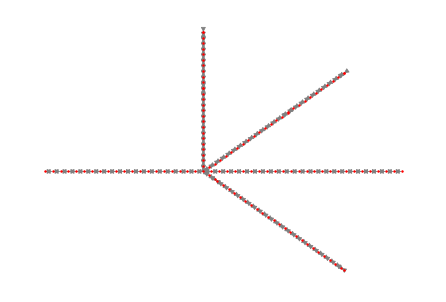

In [40]:
# show graph
energy_consumption = energy_M8_path_3_dir2['energy_consumption_kWh'] 
for edge in FG.edges(data = True):
    edge_width = FG.edges[(edge[0], edge[1])]['Info']['energy_consumption']*0.005
edge_colors = ["grey"]

# mapping = {0: "a", 1: "b", 2: "c"}
# H = nx.relabel_nodes(FG, mapping)
# nx.draw_networkx(FG, positions)
nx.draw(FG, positions, node_size=2, width = edge_width, edge_color = edge_colors, node_color = 'r')


plt.savefig('graph.pdf', bbox_inches = 'tight', dpi=600, format='pdf') 
plt.show()


### Inspect results

In [41]:
df_vessel_log = pd.DataFrame(vessel.log)
df_vessel_log

,Message,Timestamp,Value,Geometry
